In [40]:
%matplotlib inline

import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
import numpy as np

In [41]:
# constant random seed 
seed = 3232

# Connect to a pre-existing cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,48 mins 08 secs
H2O cluster timezone:,America/Denver
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,23 days
H2O cluster name:,H2O_from_python_pivotal_g3qr87
H2O cluster total nodes:,1
H2O cluster free memory:,2.360 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [42]:
from h2o.utils.shared_utils import _locate # private function. used to find files within h2o git project directory.

df = h2o.import_file(path=_locate("storymanagement.csv"))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [43]:
df.describe()

Rows:4946
Cols:20




,Id,Title,Labels,Iteration,Iteration Start,Iteration End,Type,Estimate,Current State,Created at,Accepted at,Deadline,Requested By,Description,URL,Zendesk ID,Integration,Owned By,Owned By 2,Owned By 3
type,int,string,enum,int,enum,enum,enum,int,enum,enum,enum,string,enum,string,string,int,enum,enum,enum,enum
mins,500.0,NaN,,1.0,,,,0.0,,,,NaN,,NaN,NaN,18665.0,,,,
mean,105972533.81592357,NaN,,143.33248407643313,,,,1.043905635648755,,,,0.0,,NaN,NaN,37677.06086956522,,,,
maxs,153933352.0,NaN,,34805.0,,,,8.0,,,,NaN,,NaN,NaN,55086.0,,,,
sigma,30729780.90312876,NaN,,509.55840527466114,,,,0.7279246594106115,,,,-0.0,,NaN,NaN,9846.203651439662,,,,
zeros,0,0,,0,,,,289,,,,0,,0,0,0,,,,
missing,236,150,1472,236,219,221,229,3420,236,235,289,4939,236,1358,235,4716,4715,606,2362,4701
0,48348515.0,Figure out how to organize the code,infrastructure,1.0,"Apr 15, 2013","Apr 21, 2013",chore,nan,accepted,"Apr 18, 2013","Apr 18, 2013",,Ryan Dy,,https://www.pivotaltracker.com/story/show/48348515,nan,,Thomas Bukowski,,
1,48373011.0,Set up new repo for Next,infrastructure,5.0,"May 13, 2013","May 19, 2013",chore,nan,accepted,"Apr 18, 2013","May 14, 2013",,Thomas Bukowski,,https://www.pivotaltracker.com/story/show/48373011,nan,,Thomas Bukowski,,
2,49779379.0,setup gemspec for charlotte,,5.0,"May 13, 2013","May 19, 2013",chore,nan,accepted,"May 13, 2013","May 14, 2013",,Ryan Dy,,https://www.pivotaltracker.com/story/show/49779379,nan,,Ryan Dy,,


In [44]:
# Does preprocessing on the raw data frame
def preprocess(df):
    df_edited = df
    
    for field in ["id", "Current State", "Requested By", "URL", "Zendesk ID", "Integration", "Labels",
                  "Owned By", "Owned By 2", "Owned By 3", "Iteration Start", "Iteration End", "Created at", 
                  "Accepted at"
                 ]: 
        try:
            df_edited = df_edited.drop(field)
        except:
            pass

    # Convert fields to logical factors
    df_edited['Estimate'] = df_edited['Estimate'].asfactor()
    df_edited['Iteration'] = df_edited['Iteration'].asfactor()
    df_edited['Type'] = df_edited['Type'].asfactor() #drop non-features altogether?
    
    return df_edited


In [49]:
# Set Stop Words
# The STOP WORDS we are importing are from the nltk package
import pandas as pd
import os

# Use local data file or download from GitHub
docker_data_path = "/home/h2o/data/nlp/stopwords.csv"
if os.path.isfile(docker_data_path):
  data_path = docker_data_path
else:
  data_path = "https://raw.githubusercontent.com/h2oai/h2o-tutorials/master/h2o-world-2017/nlp/stopwords.csv"

STOP_WORDS = pd.read_csv(data_path, header=0)
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

# Break titles into sequence of words
words = tokenize(df_edited["Description"])

words.head()

C1
like
file
name
changes
size
etc
""
pr
https
github


In [50]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

# This takes time to run - left commented out
w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [75]:
w2v_model.find_synonyms("text", count = 5)

OrderedDict([('description', 0.9480673670768738),
             ('mode', 0.9363235831260681),
             ('new', 0.9280204176902771),
             ('add', 0.9190223217010498),
             ('workspace', 0.9154120683670044)])

In [ ]:
df_edited = preprocess(df)

train,test,valid = df_edited.split_frame(ratios=[.85, .1], seed = seed)

In [29]:
# See that the data is ready
train.describe()

Rows:30
Cols:7




,Id,Title,Iteration,Type,Estimate,Deadline,Description
type,int,string,enum,enum,enum,int,string
mins,135086499.0,NaN,,,,NaN,NaN
mean,143737235.50000003,NaN,,,,0.0,NaN
maxs,150727910.0,NaN,,,,NaN,NaN
sigma,4704531.071147165,NaN,,,,-0.0,NaN
zeros,0,0,,,,0,0
missing,0,0,0,0,25,30,5
0,135086499.0,Handle attachment parameter in comment create and update commands on the server,204,feature,1,nan,"### [PR 1088](https://github.com/pivotaltracker/tracker/pull/1088) CommentCreate & CommentUpdate command can accept a ""attachments"" field. The `Attachments` field and the `file/google_attachments` fields are mutually exclusive and will error if both types are in the parameters. The parameters for attachments should be backwards compatible. However, we do not need forward compatibility because we will switch to results processing before we start sending new parameters from stories view (#138675351, #137978163)."
1,141424575.0,Project color not retained after reload if changed in project or workspace edit (on www) or just workspace (on ondeck),204,bug,,nan,1. Got to a project on www 2. Change its color 3. reload the page- old color is back 4. Got to a workspace on on deck 5. Click manage workspace icon (tooltip says project count not manage Workspace - may be hard for users to find BTW. Hopefully they'll guess which item under Settings allows colors to be changed) 6. Click a color to change it. 7. It seems to change in sidebar but does not change in workspace. 8. Reload page - old color back in sidebar and remains in workspace panels.
2,139907661.0,A warning dialog appears if attempting to download an attachment with an unknown filetype.,204,bug,,nan,"### [PR 1179](https://github.com/pivotaltracker/tracker/pull/1179) ~~[PR 1067](https://github.com/pivotaltracker/tracker/pull/1067)~~ This behavior reproduces using the new comment styling. 1. Add a comment with an attachment that is an unknown type. (See attached.) 2. Edit the comment. 3. Click the attachment. (Click any attachment with an unknown file type - it is not limited to attachments in the comment under edit.) Expected: If it works like the existing behavior, it downloads. Actual: A navigation warning appears (see attached.)"


In [8]:
# Run GBM
gbm_model = H2OGradientBoostingEstimator(distribution = "gaussian", ntrees=100, learn_rate=.01)
gbm_model.train(x=list(range(0,train.ncol - 1)), y="count", training_frame=train, validation_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [9]:
# Run GLM
glm_model = H2OGeneralizedLinearEstimator(family= "gaussian", lambda_ = 0, compute_p_values = True)
glm_model.train(x=list(range(0,train.ncol - 1)), y="count", training_frame=train, validation_frame=train)


glm Model Build progress: |███████████████████████████████████████████████| 100%


In [10]:
# Run AutoML
x = train.columns
y = "count"
x.remove(y)
aml = H2OAutoML(max_runtime_secs = 30, seed = seed)
aml.train(x = x, y = y,
          training_frame = train,
          validation_frame = valid,
          leaderboard_frame = test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [11]:
# Get the metrics for the different techniques
gbm_metrics = gbm_model.model_performance(test)
glm_metrics = glm_model.model_performance(test)
lb = aml.leaderboard
aml_leader_metrics = aml.leader.model_performance(test)

p = 100 # for display
print('RMSE (root mean squared error) for each algorithm')
print(f"gbm = {int(gbm_metrics['RMSE']*p)/p}, glm = {int(glm_metrics['RMSE']*p)/p}, autoML = {int(aml_leader_metrics['RMSE']*p)/p}")
print('')
lb

RMSE (root mean squared error) for each algorithm
gbm = 146.69, glm = 147.68, autoML = 140.03



model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_0_AutoML_20181015_114922,19610.3,140.037,19610.3,103.245,1.27023
StackedEnsemble_BestOfFamily_0_AutoML_20181015_114922,19685,140.303,19685,103.49,1.27134
GBM_grid_0_AutoML_20181015_114922_model_0,19687.4,140.312,19687.4,104.908,1.29589
GBM_grid_0_AutoML_20181015_114922_model_1,19711.5,140.398,19711.5,105.059,1.29849
GBM_grid_0_AutoML_20181015_114922_model_4,19799.4,140.71,19799.4,105.459,1.29855
GBM_grid_0_AutoML_20181015_114922_model_2,19804.6,140.729,19804.6,105.23,1.28894
GBM_grid_0_AutoML_20181015_114922_model_3,20075.5,141.688,20075.5,105.173,1.28516
XRT_0_AutoML_20181015_114922,20444.2,142.983,20444.2,104.596,1.28861
GBM_grid_0_AutoML_20181015_114922_model_5,20844.9,144.378,20844.9,111.035,1.40468
DRF_0_AutoML_20181015_114922,21210.3,145.638,21210.3,106.397,1.27878


In [12]:
# Now, try to make some predictions!

raw_inputs = h2o.import_file(path=_locate("test.csv"))
preprocessed_inputs = preprocess(raw_inputs)
preds = aml.leader.predict(preprocessed_inputs)

Parse progress: |█████████████████████████████████████████████████████████| 100%
stackedensemble prediction progress: |████████████████████████████████████| 100%


season,holiday,workingday,weather,temp,atemp,humidity,windspeed,datetime,season0,holiday0,workingday0,weather0,temp0,atemp0,humidity0,windspeed0,dayofweek,dayofmonth,hourofday,year,month
1,0,1,1,10.66,11.365,56,26.0027,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,Thu,20,0,2011,1
1,0,1,1,10.66,13.635,56,0,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0,Thu,20,1,2011,1
1,0,1,1,10.66,13.635,56,0,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0,Thu,20,2,2011,1
1,0,1,1,10.66,12.88,56,11.0014,2011-01-20 03:00:00,1,0,1,1,10.66,12.88,56,11.0014,Thu,20,3,2011,1
1,0,1,1,10.66,12.88,56,11.0014,2011-01-20 04:00:00,1,0,1,1,10.66,12.88,56,11.0014,Thu,20,4,2011,1
1,0,1,1,9.84,11.365,60,15.0013,2011-01-20 05:00:00,1,0,1,1,9.84,11.365,60,15.0013,Thu,20,5,2011,1
1,0,1,1,9.02,10.605,60,15.0013,2011-01-20 06:00:00,1,0,1,1,9.02,10.605,60,15.0013,Thu,20,6,2011,1
1,0,1,1,9.02,10.605,55,15.0013,2011-01-20 07:00:00,1,0,1,1,9.02,10.605,55,15.0013,Thu,20,7,2011,1
1,0,1,1,9.02,10.605,55,19.0012,2011-01-20 08:00:00,1,0,1,1,9.02,10.605,55,19.0012,Thu,20,8,2011,1
1,0,1,2,9.84,11.365,52,15.0013,2011-01-20 09:00:00,1,0,1,2,9.84,11.365,52,15.0013,Thu,20,9,2011,1


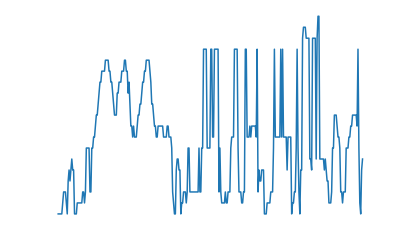

In [13]:
# now, display the predictions
raw_inputs['dayofweek'] = raw_inputs['datetime'].dayOfWeek().asfactor()
raw_inputs['dayofmonth'] = raw_inputs['datetime'].day().asfactor()
raw_inputs['hourofday'] = raw_inputs['datetime'].hour().asfactor()
raw_inputs['year'] = raw_inputs['datetime'].year().asfactor()
raw_inputs['month'] = raw_inputs['datetime'].month().asfactor()

table_with_predictions = preprocessed_inputs.concat(raw_inputs, preds)
table_with_predictions.show()


table = np.transpose(np.array(table_with_predictions.as_data_frame(use_pandas=False, header=False)))
y = table[13] # predictions
table2 = np.transpose(np.array(raw_inputs.as_data_frame(use_pandas=False, header=False)))
x = table2[0]


# plot first 2 weeks of predictions
plt.plot(x[0:336], y[0:336])
plt.axis('off')
plt.show()
